In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
file_path = './cox-violent-parsed_filt.csv'
data = pd.read_csv(file_path)

## False Positive Rate by Race — General Recidivism
We consider a positive prediction when `score_text` indicates "High" risk for general recidivism (COMPAS risk of recidivism). False positives are those predicted positive among individuals who did not recidivate (`is_recid == 0`).

In [ ]:
required_cols = {"race", "is_violent_recid", "v_score_text"}
missing = [c for c in required_cols if c not in data.columns]
if missing:
    raise KeyError(f"Missing columns in dataset: {missing}")

_df = data.copy()

_df = _df[_df["is_violent_recid"].isin([0, 1])]

pos_labels = {"High"}
_df["pred_positive"] = _df["v_score_text"].fillna("").astype(str).str.strip().isin(pos_labels)

race_idx = _df["race"]
negatives = (_df["is_violent_recid"] == 0).groupby(race_idx, dropna=False).sum()
false_pos = (((_df["is_violent_recid"] == 0) & _df["pred_positive"]).groupby(race_idx, dropna=False).sum())

fpr = (false_pos / negatives).replace([np.inf, -np.inf], np.nan)

fpr_df = (
    pd.DataFrame({
        "race": negatives.index.astype(str),
        "negatives": negatives.values,
        "false_positives": false_pos.values,
        "fpr": fpr.values,
    })
    .sort_values("fpr", ascending=False)
    .reset_index(drop=True)
)

try:
    display(fpr_df)
except Exception:
    print(fpr_df)

,race,negatives,false_positives,fpr
0,African-American,8950,1573,0.175754
1,Hispanic,1366,108,0.079063
2,Caucasian,5743,348,0.060596
3,Native American,51,3,0.058824
4,Asian,64,3,0.046875
5,Other,803,26,0.032379


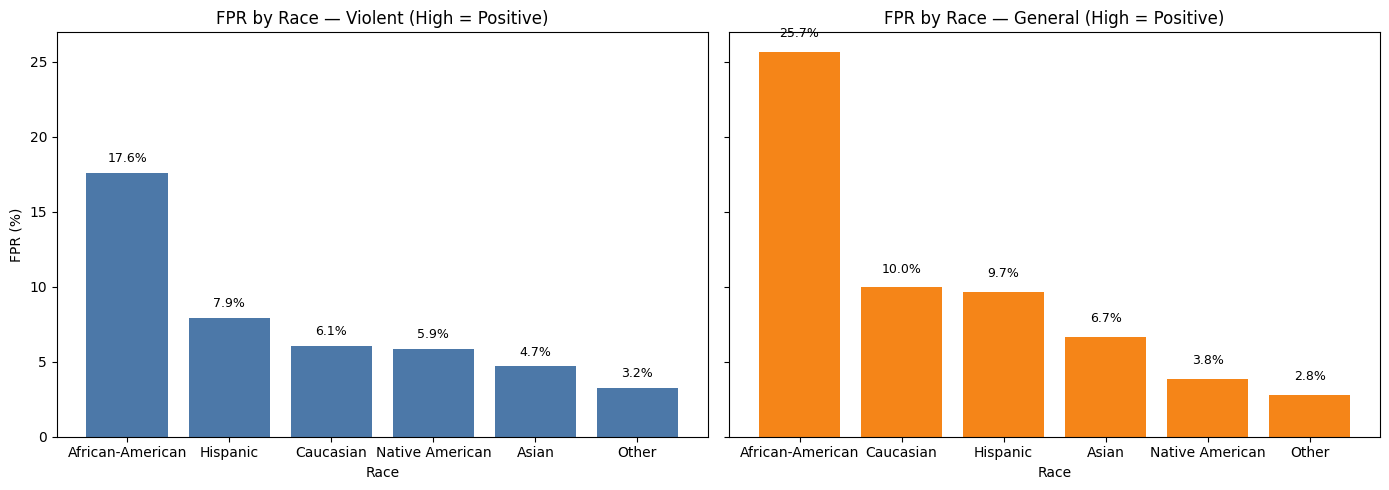

,race,negatives,false_positives,fpr
0,African-American,8950,1573,0.175754
1,Hispanic,1366,108,0.079063
2,Caucasian,5743,348,0.060596
3,Native American,51,3,0.058824
4,Asian,64,3,0.046875
5,Other,803,26,0.032379


,race,negatives,false_positives,fpr
0,African-American,4338,1114,0.256800
1,Caucasian,3308,330,0.099758
2,Hispanic,860,83,0.096512
3,Asian,45,3,0.066667
4,Native American,26,1,0.038462
5,Other,502,14,0.027888


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

required_cols_gen = {"race", "is_recid", "score_text"}
missing_gen = [c for c in required_cols_gen if c not in data.columns]
if missing_gen:
    raise KeyError(f"Missing columns in dataset for general recidivism: {missing_gen}")

_df_g = data.copy()
_df_g = _df_g[_df_g["is_recid"].isin([0, 1])]
_df_g["pred_positive_gen"] = _df_g["score_text"].fillna("").astype(str).str.strip().eq("High")

race_idx_g = _df_g["race"]
negatives_g = (_df_g["is_recid"] == 0).groupby(race_idx_g, dropna=False).sum()
false_pos_g = (((_df_g["is_recid"] == 0) & _df_g["pred_positive_gen"]).groupby(race_idx_g, dropna=False).sum())

fpr_g = (false_pos_g / negatives_g).replace([np.inf, -np.inf], np.nan)

fpr_gen_df = (
    pd.DataFrame({
        "race": negatives_g.index.astype(str),
        "negatives": negatives_g.values,
        "false_positives": false_pos_g.values,
        "fpr": fpr_g.values,
    })
    .sort_values("fpr", ascending=False)
    .reset_index(drop=True)
)

_df_v = data.copy()
_df_v = _df_v[_df_v["is_violent_recid"].isin([0, 1])]
_df_v["pred_positive_v"] = _df_v["v_score_text"].fillna("").astype(str).str.strip().eq("High")

race_idx_v = _df_v["race"]
negatives_v = (_df_v["is_violent_recid"] == 0).groupby(race_idx_v, dropna=False).sum()
false_pos_v = (((_df_v["is_violent_recid"] == 0) & _df_v["pred_positive_v"]).groupby(race_idx_v, dropna=False).sum())

fpr_v = (false_pos_v / negatives_v).replace([np.inf, -np.inf], np.nan)

fpr_viol_df = (
    pd.DataFrame({
        "race": negatives_v.index.astype(str),
        "negatives": negatives_v.values,
        "false_positives": false_pos_v.values,
        "fpr": fpr_v.values,
    })
    .sort_values("fpr", ascending=False)
    .reset_index(drop=True)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

vals_v = fpr_viol_df["fpr"] * 100
axes[0].bar(fpr_viol_df["race"], vals_v, color="#4C78A8")
axes[0].set_title("FPR by Race — Violent (High = Positive)")
axes[0].set_ylabel("FPR (%)")
axes[0].set_xlabel("Race")
for i, v in enumerate(vals_v):
    if pd.isna(v):
        continue
    axes[0].text(i, v + max(0.5, (vals_v.max() if len(vals_v) else 0) * 0.03), f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

vals_g = fpr_gen_df["fpr"] * 100
axes[1].bar(fpr_gen_df["race"], vals_g, color="#F58518")
axes[1].set_title("FPR by Race — General (High = Positive)")
axes[1].set_xlabel("Race")
for i, v in enumerate(vals_g):
    if pd.isna(v):
        continue
    axes[1].text(i, v + max(0.5, (vals_g.max() if len(vals_g) else 0) * 0.03), f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

try:
    from IPython.display import display
    display(fpr_viol_df)
    display(fpr_gen_df)
except Exception:
    print(fpr_viol_df)
    print(fpr_gen_df)

## Fairness metrics by race: FNR, Demographic Parity, Equal Opportunity
We compute, by race:
- False Negative Rate (FNR): FN / Positives
- Demographic Parity (DP): Predicted positive rate
- Equal Opportunity (EO): True Positive Rate (TPR)

We report these for violent risk (v_score_text) and general recidivism (score_text), using "High" as the positive prediction in both cases.

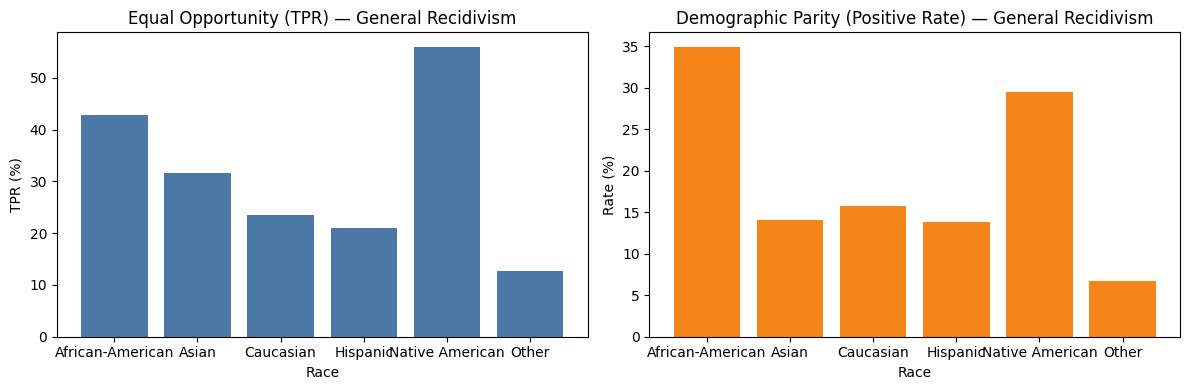

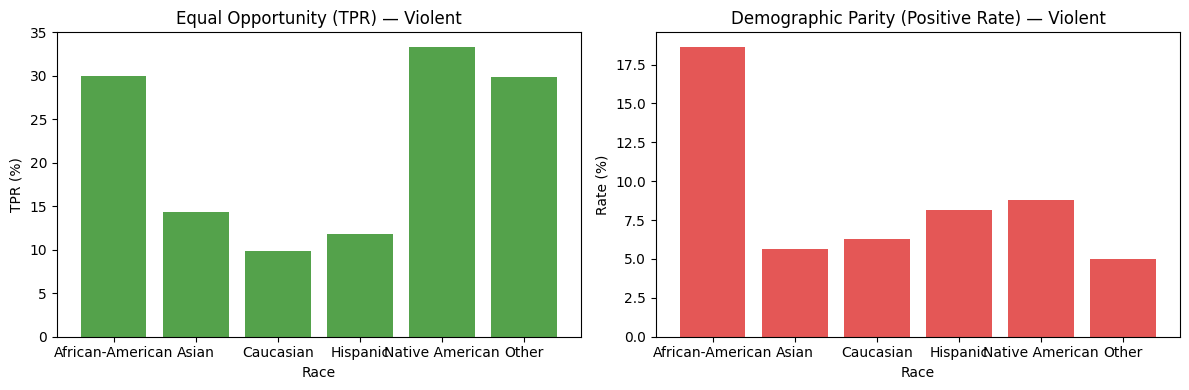

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_metrics(df, label_col, pred_positive_series, group_col="race"):
    df = df.copy()
    df = df[df[label_col].isin([0, 1])]
    df["pred_pos"] = pred_positive_series.reindex(df.index).astype(bool)

    P = (df[label_col] == 1).groupby(df[group_col], dropna=False).sum()
    N = (df[label_col] == 0).groupby(df[group_col], dropna=False).sum()
    TP = (((df[label_col] == 1) & df["pred_pos"]).groupby(df[group_col], dropna=False).sum())
    FN = (((df[label_col] == 1) & (~df["pred_pos"])) .groupby(df[group_col], dropna=False).sum())
    FP = (((df[label_col] == 0) & df["pred_pos"]).groupby(df[group_col], dropna=False).sum())

    # Metrics
    FNR = (FN / P).replace([np.inf, -np.inf], np.nan)
    TPR = (TP / P).replace([np.inf, -np.inf], np.nan)
    DP = (df["pred_pos"].groupby(df[group_col], dropna=False).mean())

    out = pd.DataFrame({
        group_col: P.index.astype(str),
        "P": P.values,
        "N": N.values,
        "TP": TP.values,
        "FN": FN.values,
        "FP": FP.values,
        "FNR": FNR.values,
        "TPR": TPR.values,
        "DP": DP.values,
    }).sort_values(group_col).reset_index(drop=True)
    return out

# Violent: positive if v_score_text == 'High'
_df_v = data.copy()
viol_pred = _df_v["v_score_text"].fillna("").astype(str).str.strip().eq("High")
metrics_violent = compute_metrics(_df_v, label_col="is_violent_recid", pred_positive_series=viol_pred)

# General: positive if score_text == 'High'
_df_g2 = data.copy()
gen_pred = _df_g2["score_text"].fillna("").astype(str).str.strip().eq("High")
metrics_general = compute_metrics(_df_g2, label_col="is_recid", pred_positive_series=gen_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(metrics_general["race"], metrics_general["TPR"] * 100, color="#4C78A8")
axes[0].set_title("Equal Opportunity (TPR) — General Recidivism")
axes[0].set_ylabel("TPR (%)")
axes[0].set_xlabel("Race")

axes[1].bar(metrics_general["race"], metrics_general["DP"] * 100, color="#F58518")
axes[1].set_title("Demographic Parity (Positive Rate) — General Recidivism")
axes[1].set_ylabel("Rate (%)")
axes[1].set_xlabel("Race")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(metrics_violent["race"], metrics_violent["TPR"] * 100, color="#54A24B")
axes[0].set_title("Equal Opportunity (TPR) — Violent")
axes[0].set_ylabel("TPR (%)")
axes[0].set_xlabel("Race")

axes[1].bar(metrics_violent["race"], metrics_violent["DP"] * 100, color="#E45756")
axes[1].set_title("Demographic Parity (Positive Rate) — Violent")
axes[1].set_ylabel("Rate (%)")
axes[1].set_xlabel("Race")
plt.tight_layout()
plt.show()

# Baseline ML Pipeline for COMPAS — Predicting is_recid
This section builds a reproducible baseline to predict general recidivism (`is_recid`), evaluates overall performance, reports group metrics by sensitive attributes (race, sex), computes fairness metrics, and prepares a baseline for mitigation.

Counts by race:
 race
African-American    9419
Caucasian           5782
Hispanic            1355
Other                825
Asian                 64
Native American       51
Name: count, dtype: int64

Counts by sex:
 sex
Male      14277
Female     3219
Name: count, dtype: int64

Class balance (is_recid=0/1):
 is_recid
0    9079
1    8417
Name: count, dtype: int64

Percent by race (%):
 race
African-American    53.84
Caucasian           33.05
Hispanic             7.74
Other                4.72
Asian                0.37
Native American      0.29
Name: count, dtype: float64

Percent by sex (%):
 sex
Male      81.6
Female    18.4
Name: count, dtype: float64


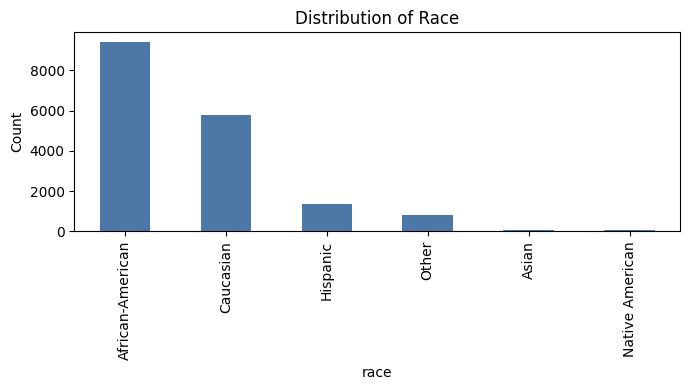

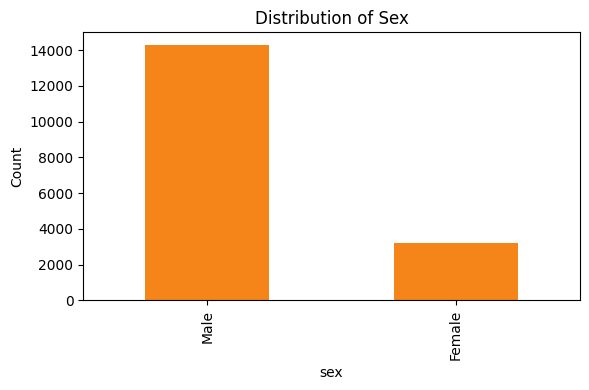

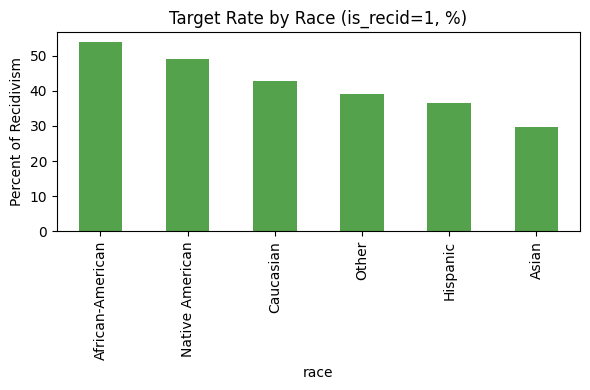

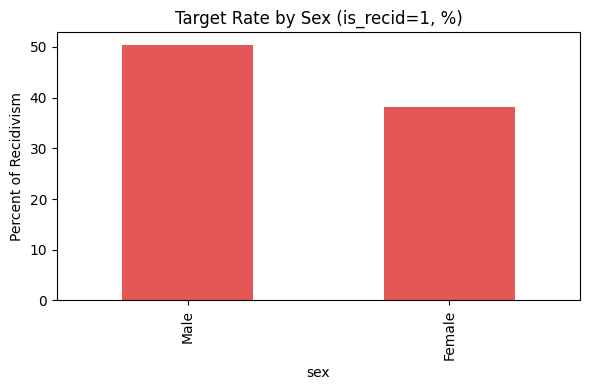

Saved figures to: C:\Users\PC\Documents\Uni\RAI\reports\figures


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

reports_dir = Path("reports"); reports_dir.mkdir(parents=True, exist_ok=True)
figs_dir = reports_dir / "figures"; figs_dir.mkdir(parents=True, exist_ok=True)

_df = data.copy()

_df = _df[_df["is_recid"].isin([0, 1])].copy()

for col in ["race", "sex", "score_text"]:
    if col in _df.columns:
        _df[col] = _df[col].astype(str).str.strip()

race_counts = _df["race"].value_counts(dropna=False)
sex_counts = _df["sex"].value_counts(dropna=False)
class_counts = _df["is_recid"].value_counts().sort_index()

print("Counts by race:\n", race_counts)
print("\nCounts by sex:\n", sex_counts)
print("\nClass balance (is_recid=0/1):\n", class_counts)

race_pct = (race_counts / len(_df) * 100).round(2)
sex_pct = (sex_counts / len(_df) * 100).round(2)
print("\nPercent by race (%):\n", race_pct)
print("\nPercent by sex (%):\n", sex_pct)

plt.figure(figsize=(7,4))
(_df["race"].value_counts().sort_values(ascending=False)).plot(kind="bar", color="#4C78A8")
plt.title("Distribution of Race")
plt.ylabel("Count")
plt.tight_layout(); plt.savefig(figs_dir / "dist_race.png", dpi=150); plt.show()

plt.figure(figsize=(6,4))
(_df["sex"].value_counts().sort_values(ascending=False)).plot(kind="bar", color="#F58518")
plt.title("Distribution of Sex")
plt.ylabel("Count")
plt.tight_layout(); plt.savefig(figs_dir / "dist_sex.png", dpi=150); plt.show()

plt.figure(figsize=(6,4))
(_df.groupby("race")["is_recid"].mean().sort_values(ascending=False) * 100).plot(kind="bar", color="#54A24B")
plt.title("Target Rate by Race (is_recid=1, %)")
plt.ylabel("Percent of Recidivism")
plt.tight_layout(); plt.savefig(figs_dir / "target_rate_by_race.png", dpi=150); plt.show()

plt.figure(figsize=(6,4))
(_df.groupby("sex")["is_recid"].mean().sort_values(ascending=False) * 100).plot(kind="bar", color="#E45756")
plt.title("Target Rate by Sex (is_recid=1, %)")
plt.ylabel("Percent of Recidivism")
plt.tight_layout(); plt.savefig(figs_dir / "target_rate_by_sex.png", dpi=150); plt.show()

print("Saved figures to:", figs_dir.resolve())


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
)
from sklearn.impute import SimpleImputer
from joblib import dump

num_features = [c for c in ["age", "priors_count", "decile_score"] if c in _df.columns]
cat_features = [c for c in ["race", "sex"] if c in _df.columns]

X = _df[num_features + cat_features].copy()
y = _df["is_recid"].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

preprocessor = ColumnTransformer([
    ("num", Pipeline([("impute", SimpleImputer(strategy="median")),
                      ("scale", StandardScaler())]), num_features),
    ("cat", Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                      ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))]), cat_features),
])

model = LogisticRegression(max_iter=1000, class_weight="balanced")

pipe = Pipeline(steps=[("pre", preprocessor), ("clf", model)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

metrics_overall = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "roc_auc": roc_auc_score(y_test, y_prob) if len(np.unique(y_test)) > 1 else np.nan,
}
print("Overall metrics:", metrics_overall)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

pd.DataFrame([metrics_overall]).to_csv(reports_dir / "metrics_overall.csv", index=False)

dump(pipe, reports_dir / "base_logreg.joblib")
print("Saved:", (reports_dir / "metrics_overall.csv").resolve())
print("Saved model to:", (reports_dir / "base_logreg.joblib").resolve())


Overall metrics: {'accuracy': 0.6614593255858259, 'precision': np.float64(0.6473601260835303), 'recall': np.float64(0.6506930693069307), 'f1': np.float64(0.64902231878333), 'roc_auc': np.float64(0.7153042264578882)}

Classification report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      2724
           1       0.65      0.65      0.65      2525

    accuracy                           0.66      5249
   macro avg       0.66      0.66      0.66      5249
weighted avg       0.66      0.66      0.66      5249

Saved: C:\Users\PC\Documents\Uni\RAI\reports\metrics_overall.csv
Saved model to: C:\Users\PC\Documents\Uni\RAI\reports\base_logreg.joblib


Saved group reports to: C:\Users\PC\Documents\Uni\RAI\reports


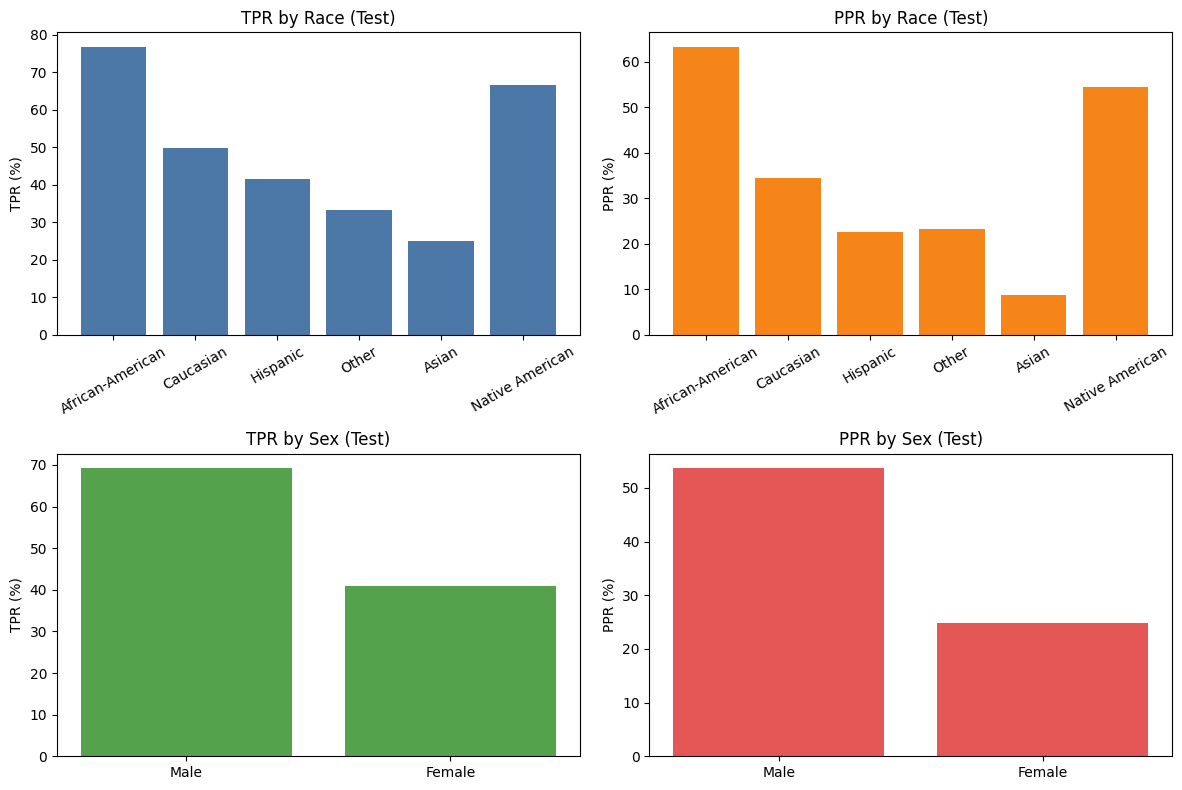

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def confusion_by_group(y_true, y_pred, group):
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "group": group})
    df["y_true"] = df["y_true"].astype(int)
    df["y_pred"] = df["y_pred"].astype(int)
    groups = df["group"].astype(str)
    TP = ((df["y_true"] == 1) & (df["y_pred"] == 1)).groupby(groups, dropna=False).sum()
    FP = ((df["y_true"] == 0) & (df["y_pred"] == 1)).groupby(groups, dropna=False).sum()
    TN = ((df["y_true"] == 0) & (df["y_pred"] == 0)).groupby(groups, dropna=False).sum()
    FN = ((df["y_true"] == 1) & (df["y_pred"] == 0)).groupby(groups, dropna=False).sum()
    n = df.groupby(groups, dropna=False).size()
    out = pd.DataFrame({"group": TP.index.astype(str), "TP": TP.values, "FP": FP.values, "TN": TN.values, "FN": FN.values, "n": n.values})
    return out

def safe_div(a, b):
    a = a.astype(float)
    b = b.astype(float)
    with np.errstate(divide='ignore', invalid='ignore'):
        res = a / b
        res[~np.isfinite(res)] = np.nan
    return res

def group_fairness_report(y_true, y_pred, group, group_name):
    conf = confusion_by_group(y_true, y_pred, group)
    TP, FP, TN, FN, n = conf.TP, conf.FP, conf.TN, conf.FN, conf.n
    PPR = safe_div(TP + FP, n)
    TPR = safe_div(TP, TP + FN)
    FPR = safe_div(FP, FP + TN)
    FNR = safe_div(FN, FN + TP)
    PPV = safe_div(TP, TP + FP)
    TNR = safe_div(TN, TN + FP)
    BACC = (TPR + TNR) / 2.0

    report = pd.DataFrame({
        group_name: conf["group"],
        "n": n.values,
        "PPR": PPR.values,
        "TPR": TPR.values,
        "FPR": FPR.values,
        "FNR": FNR.values,
        "PPV": PPV.values,
        "TNR": TNR.values,
        "BACC": BACC.values,
    }).sort_values("n", ascending=False).reset_index(drop=True)

    ref_ppr = report.loc[0, "PPR"] if len(report) else np.nan
    for col in ["PPR", "TPR", "FPR", "FNR", "PPV", "TNR", "BACC"]:
        report[f"{col}_diff_vs_ref"] = report[col] - report.loc[0, col]
    report["DI_vs_ref"] = safe_div(report["PPR"], ref_ppr) if pd.notna(ref_ppr) else np.nan

    return report

race_test = X_test["race"].astype(str)
sex_test = X_test["sex"].astype(str)

report_race = group_fairness_report(y_test, y_pred, race_test, group_name="race")
report_sex = group_fairness_report(y_test, y_pred, sex_test, group_name="sex")

report_race.to_csv(reports_dir / "metrics_by_group_race.csv", index=False)
report_sex.to_csv(reports_dir / "metrics_by_group_sex.csv", index=False)
print("Saved group reports to:", reports_dir.resolve())

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=False)
# Race TPR
axes[0, 0].bar(report_race["race"], report_race["TPR"] * 100, color="#4C78A8")
axes[0, 0].set_title("TPR by Race (Test)")
axes[0, 0].set_ylabel("TPR (%)")
axes[0, 0].tick_params(axis='x', rotation=30)
# Race PPR
axes[0, 1].bar(report_race["race"], report_race["PPR"] * 100, color="#F58518")
axes[0, 1].set_title("PPR by Race (Test)")
axes[0, 1].set_ylabel("PPR (%)")
axes[0, 1].tick_params(axis='x', rotation=30)
# Sex TPR
axes[1, 0].bar(report_sex["sex"], report_sex["TPR"] * 100, color="#54A24B")
axes[1, 0].set_title("TPR by Sex (Test)")
axes[1, 0].set_ylabel("TPR (%)")
# Sex PPR
axes[1, 1].bar(report_sex["sex"], report_sex["PPR"] * 100, color="#E45756")
axes[1, 1].set_title("PPR by Sex (Test)")
axes[1, 1].set_ylabel("PPR (%)")

fig.tight_layout()
fig.savefig(figs_dir / "tpr_ppr_race_sex.png", dpi=150)
plt.show()

In [ ]:
thresholds = [0.3, 0.5, 0.7]
all_reports = []
for th in thresholds:
    y_pred_th = (y_prob >= th).astype(int)
    rep_r = group_fairness_report(y_test, y_pred_th, race_test, group_name="race")
    rep_r.insert(1, "threshold", th)
    rep_s = group_fairness_report(y_test, y_pred_th, sex_test, group_name="sex")
    rep_s.insert(1, "threshold", th)
    all_reports.append((th, rep_r, rep_s))

for th, rep_r, rep_s in all_reports:
    rep_r.to_csv(reports_dir / f"metrics_by_group_race_th_{th}.csv", index=False)
    rep_s.to_csv(reports_dir / f"metrics_by_group_sex_th_{th}.csv", index=False)
print("Saved threshold sweep reports to:", reports_dir.resolve())


Saved threshold sweep reports to: C:\Users\PC\Documents\Uni\RAI\reports


## Model Card — Baseline Logistic Regression for is_recid
- Data: COMPAS (filtered to valid `is_recid` labels). Features used: age, priors_count, decile_score, race, sex.
- Task: Binary classification (predict `is_recid`).
- Split: 70/30 stratified by target.
- Preprocessing: StandardScaler (numeric), OneHotEncoder(drop="first") (categorical).
- Model: LogisticRegression(max_iter=1000, class_weight="balanced").
- Metrics (test): See `reports/metrics_overall.csv`. Group fairness: see CSVs under `reports/` and figures under `reports/figures/`.
- Fairness notes: Inspect TPR (Equal Opportunity) and PPR (Demographic Parity) gaps across race and sex; threshold sweep CSVs show trade-offs.
- Limitations: COMPAS contains known biases; features correlate with sensitive attributes; threshold choice impacts fairness; baseline only—no mitigation applied yet.

## Bias Mitigation Strategies — Algorithm-level and Post-processing

This section applies: 
- Algorithm-level constraints with Fairlearn reductions (Demographic Parity, Equalized Odds).
- Reweighting to balance group influence at training time.
- Post-processing group-specific thresholds via ThresholdOptimizer.

We evaluate overall metrics and group fairness reports (race and sex) for each approach and save CSVs under `reports/`. Figures can be added similarly if needed.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer

reports_dir = Path("reports"); reports_dir.mkdir(exist_ok=True)

def overall_metrics(y_true, y_pred, y_prob=None):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob) if y_prob is not None and len(np.unique(y_true)) > 1 else np.nan,
    }

A_race = X_train["race"].astype(str)
A_race_test = X_test["race"].astype(str)
A_sex = X_train["sex"].astype(str)
A_sex_test = X_test["sex"].astype(str)

from sklearn.base import clone
pre = clone(pipe.named_steps["pre"])  # reuse preprocessing
base_lr = LogisticRegression(max_iter=1000, class_weight="balanced")

X_train_t = pre.fit_transform(X_train, y_train)
X_test_t = pre.transform(X_test)

results = []

# 1) Reductions — Demographic Parity (by race)
constraint = DemographicParity()
mit_dp_race = ExponentiatedGradient(base_lr, constraints=constraint)
mit_dp_race.fit(X_train_t, y_train, sensitive_features=A_race)
y_pred_dp_race = mit_dp_race.predict(X_test_t)
y_prob_dp_race = None  # randomized classifier; use labels only for metrics
metrics_dp_race = overall_metrics(y_test, y_pred_dp_race, y_prob_dp_race)
results.append(("reductions_dp_race", metrics_dp_race))

# Group reports
rep_r_dp = group_fairness_report(y_test, y_pred_dp_race, A_race_test, group_name="race")
rep_s_dp = group_fairness_report(y_test, y_pred_dp_race, A_sex_test, group_name="sex")
rep_r_dp.to_csv(reports_dir / "mit_dp_race_metrics_by_group_race.csv", index=False)
rep_s_dp.to_csv(reports_dir / "mit_dp_race_metrics_by_group_sex.csv", index=False)

# 2) Reductions — Equalized Odds (by race)
constraint = EqualizedOdds()
mit_eo_race = ExponentiatedGradient(base_lr, constraints=constraint)
mit_eo_race.fit(X_train_t, y_train, sensitive_features=A_race)
y_pred_eo_race = mit_eo_race.predict(X_test_t)
metrics_eo_race = overall_metrics(y_test, y_pred_eo_race, None)
results.append(("reductions_eo_race", metrics_eo_race))
rep_r_eo = group_fairness_report(y_test, y_pred_eo_race, A_race_test, group_name="race")
rep_s_eo = group_fairness_report(y_test, y_pred_eo_race, A_sex_test, group_name="sex")
rep_r_eo.to_csv(reports_dir / "mit_eo_race_metrics_by_group_race.csv", index=False)
rep_s_eo.to_csv(reports_dir / "mit_eo_race_metrics_by_group_sex.csv", index=False)

# 3) Simple Reweighting (by race)
race_counts = A_race.value_counts()
race_weights = (1.0 / race_counts).to_dict()
sample_w = A_race.map(race_weights).astype(float)

lr_rw = LogisticRegression(max_iter=1000, class_weight=None)
lr_rw.fit(X_train_t, y_train, sample_weight=sample_w)
y_pred_rw = lr_rw.predict(X_test_t)
y_prob_rw = lr_rw.predict_proba(X_test_t)[:, 1]
metrics_rw = overall_metrics(y_test, y_pred_rw, y_prob_rw)
results.append(("reweight_race", metrics_rw))
rep_r_rw = group_fairness_report(y_test, y_pred_rw, A_race_test, group_name="race")
rep_s_rw = group_fairness_report(y_test, y_pred_rw, A_sex_test, group_name="sex")
rep_r_rw.to_csv(reports_dir / "mit_reweight_race_metrics_by_group_race.csv", index=False)
rep_s_rw.to_csv(reports_dir / "mit_reweight_race_metrics_by_group_sex.csv", index=False)

# 4) Post-processing — ThresholdOptimizer (by race)
th_opt = ThresholdOptimizer(estimator=pipe, constraints="equalized_odds", prefit=True)
th_opt.fit(X_train, y_train, sensitive_features=A_race)
y_pred_th = th_opt.predict(X_test, sensitive_features=A_race_test)
metrics_th = overall_metrics(y_test, y_pred_th.astype(int), None)
results.append(("threshold_opt_equalized_odds_race", metrics_th))
rep_r_th = group_fairness_report(y_test, y_pred_th.astype(int), A_race_test, group_name="race")
rep_s_th = group_fairness_report(y_test, y_pred_th.astype(int), A_sex_test, group_name="sex")
rep_r_th.to_csv(reports_dir / "mit_threshold_opt_eo_race_metrics_by_group_race.csv", index=False)
rep_s_th.to_csv(reports_dir / "mit_threshold_opt_eo_race_metrics_by_group_sex.csv", index=False)

# Save overall metrics for each approach
pd.DataFrame([dict(approach=name, **m) for name, m in results]).to_csv(reports_dir / "mitigation_overall_metrics.csv", index=False)

print("Saved mitigation metrics to:", reports_dir.resolve())

Saved mitigation metrics to: C:\Users\PC\Documents\Uni\RAI\reports


### Comparisons: Baseline vs Mitigations (Race only)
We compare baseline against each mitigation (Demographic Parity, Equalized Odds, Reweighting, Threshold Optimizer) with side-by-side bars for TPR (EO) and PPR (DP) by race. Figures are saved under `reports/figures/`.

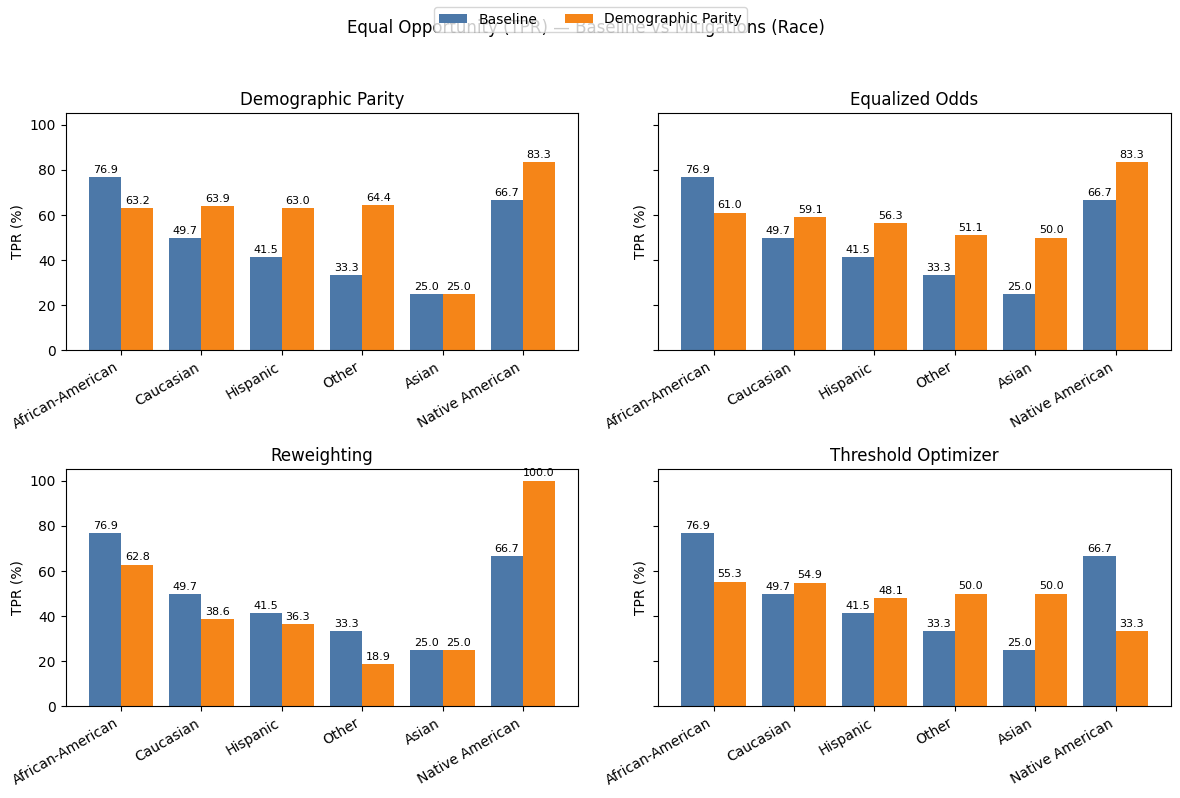

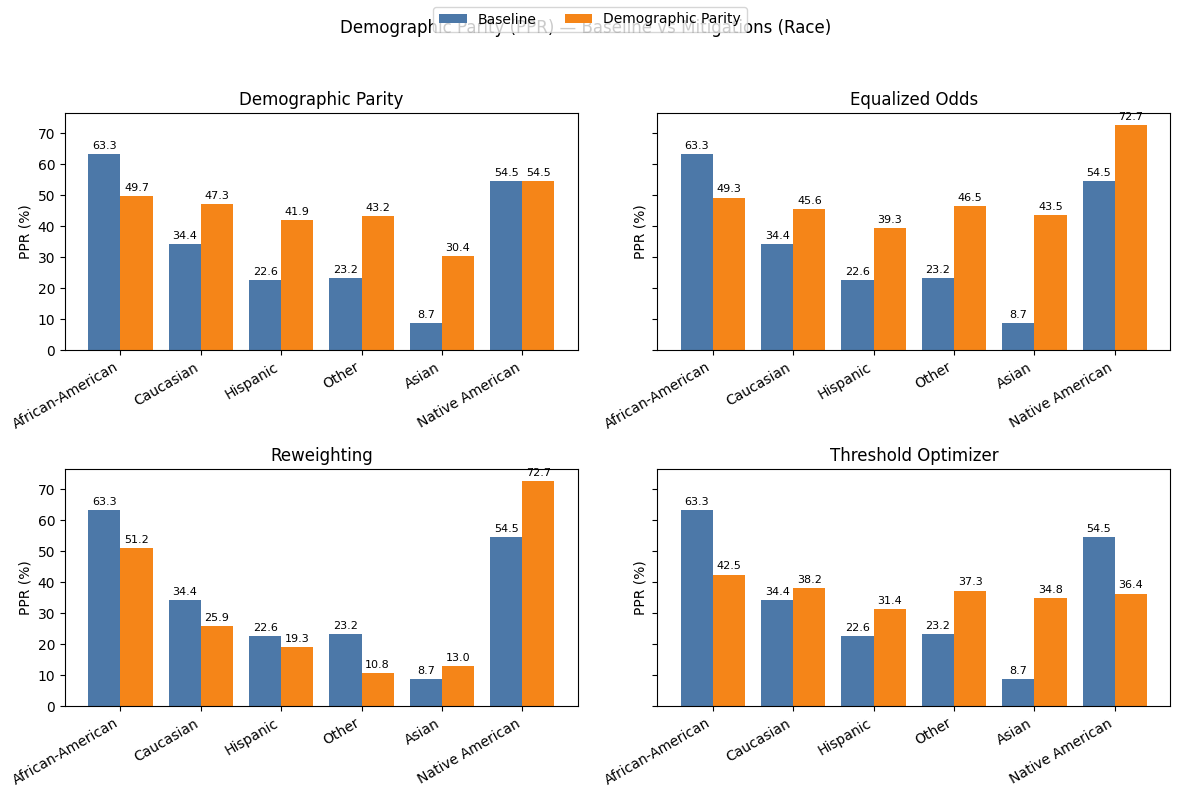

Saved comparison plots to: C:\Users\PC\Documents\Uni\RAI\reports\figures


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

base = Path("reports")
figs = base / "figures"
figs.mkdir(parents=True, exist_ok=True)


baseline = pd.read_csv(base / "metrics_by_group_race.csv")
mit_dp = pd.read_csv(base / "mit_dp_race_metrics_by_group_race.csv")
mit_eo = pd.read_csv(base / "mit_eo_race_metrics_by_group_race.csv")
mit_rw = pd.read_csv(base / "mit_reweight_race_metrics_by_group_race.csv")
mit_th = pd.read_csv(base / "mit_threshold_opt_eo_race_metrics_by_group_race.csv")


races = list(baseline["race"]) if "race" in baseline.columns else list(baseline.iloc[:,0])

def plot_compare(metric_key: str, title: str, fname: str):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    series = [
        (mit_dp, "Demographic Parity"),
        (mit_eo, "Equalized Odds"),
        (mit_rw, "Reweighting"),
        (mit_th, "Threshold Optimizer"),
    ]
    for ax, (df, label) in zip(axes.flat, series):
        
        b = baseline.set_index("race").reindex(races)
        m = df.set_index("race").reindex(races)
        
        width = 0.4
        x = range(len(races))
        ax.bar([i - width/2 for i in x], (b[metric_key] * 100).values, width=width, label="Baseline", color="
        ax.bar([i + width/2 for i in x], (m[metric_key] * 100).values, width=width, label=label, color="
        ax.set_title(label)
        ax.set_xticks(list(x))
        ax.set_xticklabels(races, rotation=30, ha="right")
        ax.set_ylabel(f"{metric_key} (%)")
        
        for i, (bv, mv) in enumerate(zip((b[metric_key]*100).values, (m[metric_key]*100).values)):
            if pd.notna(bv):
                ax.text(i - width/2, bv + 1, f"{bv:.1f}", ha="center", va="bottom", fontsize=8)
            if pd.notna(mv):
                ax.text(i + width/2, mv + 1, f"{mv:.1f}", ha="center", va="bottom", fontsize=8)
    fig.suptitle(title)
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(figs / fname, dpi=150)
    plt.show()


plot_compare("TPR", "Equal Opportunity (TPR) — Baseline vs Mitigations (Race)", "compare_tpr_race.png")

plot_compare("PPR", "Demographic Parity (PPR) — Baseline vs Mitigations (Race)", "compare_ppr_race.png")

print("Saved comparison plots to:", figs.resolve())